In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import skewer_computations as skc
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d

Load the data

In [183]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
# set phase
phase = "sim_minus"
# set axis number
axis = 1

In [184]:
# load the skewers x 
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x'] # these are already normalized
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is still wrong for some reason, redefined below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.



pixel spacing is 0.05 Mpc


In [185]:
Np = delta_flux_x.shape[1]
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 10
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux_b, xpar_b = est.bin_spectra(delta_flux_x, xpar, binsize)
Np_b=delta_flux_b.shape[1]
pix_spacing_b = xpar_b[1]-xpar_b[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing_b} Mpc")
delta_flux_k = np.fft.rfft(delta_flux_b)*np.sqrt(pix_spacing_b/Np_b)
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=False
nsub=5000
if subsel:
    randoms = rng.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_x[~sel] = np.nan
delta_flux_b[~sel] = np.nan
delta_flux_k[~sel] = np.nan

# make masked arrays
delta_flux_x = np.ma.masked_invalid(delta_flux_x)
delta_flux_b = np.ma.masked_invalid(delta_flux_b)
delta_flux_k = np.ma.masked_invalid(delta_flux_k)
positions_sel = np.ma.masked_invalid(positions_sel)

# reshape into a grid
delta_flux_x = np.reshape(delta_flux_x, (int(nside), int(nside), Np))
delta_flux_b = np.reshape(delta_flux_b, (int(nside), int(nside), Np_b))
delta_flux_k = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))


Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 135
Spacing between pixels along line-of-sight after binning = 0.49999999999999994 Mpc
spacing between neighboring skewers is 0.09 Mpc


In [186]:
delta_x_matrix_binned = est.make_delta_x_matrix(L, Np_b, xpar_b)

Load the model

In [12]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)


In [13]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

[3.]


In [14]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [187]:
# Get the weighting matrix
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine # to cancel the Mpc.
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C0_mat_b = est.c0(xi_fid_func, delta_x_matrix_binned)
C0_invmat_b = np.linalg.inv(C0_mat_b)
# get the fiducial signal
S_fiducial_b = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix_binned, pix_spacing_b)

In [188]:
kpar_b = np.fft.rfftfreq(Np_b, pix_spacing_b)*2*np.pi # frequency in Mpc^-1
kmax = np.pi/pix_spacing_b
kbin_spacing = kpar_b[1]-kpar_b[0]

# make a set of bins with kpar_b as centers
kbin_est = np.array([[kp-(kpar_b[1]-kpar_b[0])/2, kp+(kpar_b[1]-kpar_b[0])/2] for kp in kpar_b])
Nbin = len(kbin_est)

Get the FFT measurements

Define the bin we are going to measure.

Plotting separations for bin [4.99, 5.01].
20


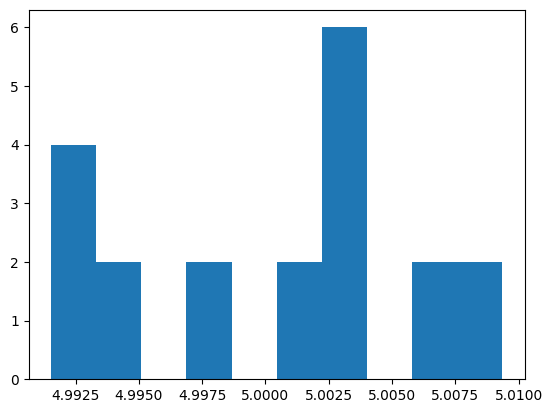

In [189]:
distances = np.linalg.norm(positions-[0,0], axis=1)
dgrid = distances.reshape(position_grid.shape[0:2])

separation_bin = [4.99, 5.01]

sbin = [separation_bin[0],separation_bin[1]]
row_off, col_off = skc.offsets_inbin(positions, position_grid.shape[0:2],sbin)

print(f"Plotting separations for bin {sbin}.")


dists_remain = []
for i in range(len(row_off)):
    dists_remain.append(dgrid[row_off[i], col_off[i]])
plt.hist(dists_remain)
print(len(dists_remain))

In [190]:
jstep = 1
imin = 0
imax = nside//4
jmin = 0
jmax = 2
Px, std, recorded_pairs = skc.Px_skewers_testmode_semicircle(delta_flux_k[:, :, :65], imin, imax, jmin, jmax, jstep, nskew, row_off, col_off)

For this cpu, there are 15360 pairs to compute.
Ns_side is 768.0
end of Px_array is 0.011822367599988772


In [181]:
np.asarray(recorded_pairs).size

245760

In [177]:
len(recorded_pairs)

61440

In [104]:
# unmask the delta_flux_b array
type(delta_flux_b)
delta_flux_b_normal = np.asarray(delta_flux_b)
type(delta_flux_b_normal)

numpy.ndarray

In [192]:
kbin_centers, theta_est, F_alpha_beta, Lalpha, Npairs = est.estimate_px(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b_normal, row_off, col_off, imax, jmax, jstep, kbin_est[:30], np.zeros(S_fiducial_b.shape), C0_invmat_b, approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.09308422677303092, 0.18616845354606185, 0.2792526803190928, 0.3723369070921237, 0.4654211338651546, 0.5585053606381856, 0.6515895874112164, 0.7446738141842474, 0.8377580409572783, 0.9308422677303092, 1.0239264945033402, 1.1170107212763711, 1.2100949480494019, 1.3031791748224328, 1.3962634015954638, 1.4893476283684948, 1.5824318551415255, 1.6755160819145567, 1.7686003086875874, 1.8616845354606184, 1.9547687622336496, 2.0478529890066803, 2.140937215779711, 2.2340214425527423, 2.327105669325773, 2.4201898960988038, 2.513274122871835, 2.6063583496448657, 2.699442576417897]
Getting derivative matrices.
Starting loop through data.
This k took 9.986703872680664 seconds
This k took 10.925991773605347 seconds
This k took 12.947394132614136 seconds
This k took 16.788940906524658 seconds
This k took 10.38927412033081 seconds
This k took 9.638199090957642 seconds
This k took 10.687772035598755 seconds
This k took 10.618527889251709 seconds
This k took 10.320

In [193]:
Npairs

15360

Bin the P1D model (initial guess) to match the binning of the $\Delta P_{1D}$ estimates

In [194]:
Nbin = len(kbin_centers)
p1d_fid = est.bin_model(kfine, p1d_fine, kbin_est, Nbin)


In [195]:
F_inv = np.linalg.inv(F_alpha_beta)


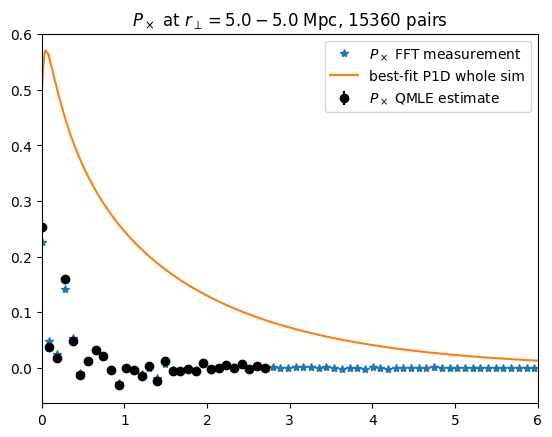

In [196]:
plt.errorbar(kbin_centers,theta_est, yerr=np.sqrt(np.diag(F_inv)), fmt='o', label=r'$P_\times$ QMLE estimate', color='black')
plt.plot(kpar_b[:65], Px, '*', label=r'$P_\times$ FFT measurement')
plt.plot(kfine, p1d_fine, label='best-fit P1D whole sim')
# plt.ylim([-1,1])
plt.title(r"$P_\times$ at $r_\perp={:.1f}-{:.1f}$ Mpc, {:d} pairs".format(sbin[0], sbin[1], Npairs))
plt.xlim([0,6])
plt.legend()

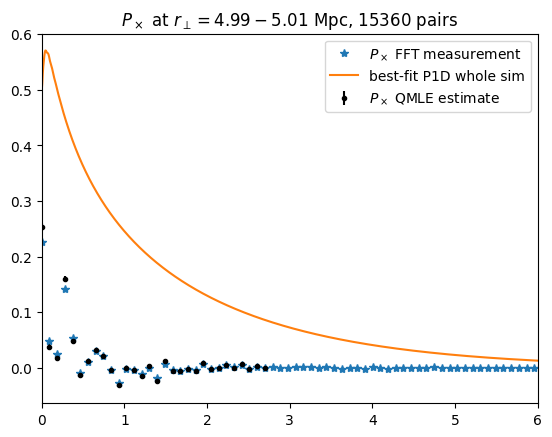

In [205]:
plt.errorbar(kbin_centers,theta_est, yerr=np.sqrt(np.diag(F_inv)), fmt='o', label=r'$P_\times$ QMLE estimate', color='black', ms=3)
plt.plot(kpar_b[:65], Px, '*', label=r'$P_\times$ FFT measurement')
plt.plot(kfine, p1d_fine, label='best-fit P1D whole sim')
# plt.ylim([-1,1])
plt.title(r"$P_\times$ at $r_\perp={:.2f}-{:.2f}$ Mpc, {:d} pairs".format(sbin[0], sbin[1], Npairs))
plt.xlim([0,6])
plt.legend()